# Deep Learning HW01
Gerald Baulig 0780827 2019/11/05
GitHub: https://github.com/bugerry87/fcnn_scratch

---

In this assignment we are asked to implement a neural network from scratch,
including Backpropagation and Storastic Gradient Decent algorithms.
The assigment includes two tasks:

1. Implement a regression network, and
2. implement a classification network.

## 1. Implement a Regression Network

Implement a regression network for the engery efficiency dataset.
I guess this dataset descripes the termal exchange of a building to its environment.
The dataset has 2 Values (t):

- Heating load, and
- Cooling load

And 8 features:

- Relative compactness,
- Surface area,
- Wall area,
- Roof area,
- Overall hight,
- Orientation,
- Glazing area, and
- Glazing area distribution.

We are required to define a feature-vector out of these features and predict the heating load of the buildings, by minimizing the "sum-of-squares" error function,

$$
\begin{equation}
E(w) = \sum_{n=1}^{N}{(t_n - y(X_n;w))^2}
\tag{1}
\end{equation}
$$

...while the evaluation should be processed by the "root-mean-square" error (basically an Euclidean distance :-),

$$
\begin{equation}
E_{RMS}(w) = \frac{\sqrt{\sum_{n=1}^{N}{(t_n - y(x_n;w))^2}}}{\sqrt{N}}
\tag{2}
\end{equation}
$$

## 2. Implement a Classifier

Implement a classification network for the Ionosphere dataset.



# A Fully-Connected Neural Network from Scratch

First, let's define what a Neural Network is.
A Neural Network is a class that can train and validate the weight of a stack of layers, w.r.t several hyper-parameters.
However, all what the Neural Network needs to know about his own network is, where to get its output from. Furthermore, the hyper-parameters are only required in the training process, but only few of them in the validation process,
such that the class defination could look like that:

In [1]:
class NeuralNetwork:
    def __init__(self, train_set, val_set, cost_func, loss_func):
        self.train_set = train_set
        self.val_set = val_set
        self.cost = cost_func
        self.loss = loss_func
        pass
    
    def train(self, output_layer, lr, lr_dec):
        self.lr = lr
        self.lr_dec = lr_dec
        self.training = True
        for Y in output_layer.poll_forward():
            Z = np.squeeze(self.cost.f(self.T, Y))
            dZ = self.cost.d(self.T, Y)
            output_layer.push_backward(dZ, self.lr)
            self.lr -= self.lr * self.lr_dec
            yield Z 
        pass
    
    def val(self, output_layer):
        self.training = False
        for Y in output_layer.poll_forward():
            Z = self.loss.f(self.T, Y)
            yield Z
        pass
    
    def gen_input(self):
        if self.training:
            for self.X, self.T, self.epoch, self.step in self.train_set():
                yield self.X
        else:
            for self.X, self.T, _, _ in self.val_set():
                yield self.X
        pass

## Activation Functions


### ReLU

In [2]:
import numpy as np
class ReLU:
    f = lambda x: np.maximum(x,0).astype(float)
    d = lambda x: (x > 0).astype(float)

#test
print(ReLU.f(np.array([1,-1,5,-5,0])))
print(ReLU.d(np.array([1,-1,5,-5,0])))

[1. 0. 5. 0. 0.]
[1. 0. 1. 0. 0.]


### Sigmoid

In [3]:
import numpy as np
class Sigmoid:
    f = lambda x: 1 / (1 + np.exp(-x))
    def d(x):
        S = Sigmoid.f(x)
        return S * (1 - S)
    pass

#test
print(Sigmoid.f(np.array([1,-1,5,-5,0])))
print(Sigmoid.d(np.array([1,-1,5,-5,0])))

[0.73105858 0.26894142 0.99330715 0.00669285 0.5       ]
[0.19661193 0.19661193 0.00664806 0.00664806 0.25      ]


### Linear

In [4]:
class Linear:
    f = lambda x: x
    d = lambda x: 1.0

## Let's Define a Fully-Connected Layer



In [122]:
class FcLayer:
    def __init__(self,
                 params,
                 act_func,
                 input_generator,
                 backprop,
                ):
        self.w = params[0]
        self.b = params[1]
        self.act = act_func
        self.input = input_generator
        self.backprop = backprop
        pass
    
    def poll_forward(self):
        '''Polls the output from the underlying layer. (Feed Forward)'''
        for self.x in self.input():
            self.y = self.act.f(np.dot(self.x, self.w) + self.b)
            yield self.y
    
    def push_backward(self, dZ, lr):
        '''Pushes the loss to the underlying layer. (Back Propagation)'''
        dZ = dZ * self.act.d(self.y)
        dw = np.dot(self.x.T, dZ)
        if self.backprop:
            self.backprop(np.dot(dZ, self.w.T), lr)
        self.w += dw * lr
        self.b += np.sum(dZ, axis=0) * lr
        

## Loss Functions


In [18]:
import numpy as np
class SOS:
    f = lambda t,y: np.sum(np.power(t - y, 2))
    d = lambda t,y: (t - y) * 2
    
class RMS:
    f = lambda t,y: np.power(SOS.f(t, y) / t.size, 0.5)
    d = lambda t,y: (SOS.d(t, y) / t.size) * 0.5

#test
print("SOS.f", SOS.f(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("SOS.d", SOS.d(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("RMS.f", RMS.f(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("RMS.d", RMS.d(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))

SOS.f 26
SOS.d [ 0 -2  0 10  0]
RMS.f 2.280350850198276
RMS.d [ 0.  -0.2  0.   1.   0. ]


# Regression for Energy Efficiency

## Load and prepare Energy Efficiency Data

In [113]:
import numpy as np

def unpack_EnergyEfficiency_data():
    raw = np.genfromtxt('EnergyEfficiency_data.csv', skip_header=1, delimiter=',')
    N = raw.shape[0]
    data = np.zeros((N,17))
    data[:,:4] = raw[:,:4]     #comp, surf, wall, roof, 
    #data[:,4] = raw[:,4]       #hight
    data[:,5] = raw[:,5] == 2  #ori north
    data[:,6] = raw[:,5] == 3  #ori east
    data[:,7] = raw[:,5] == 4  #ori south
    data[:,8] = raw[:,5] == 5  #ori west
    data[:,9] = raw[:,6]       #area
    data[:,10] = raw[:,7] == 1 #area uniform
    data[:,11] = raw[:,7] == 2 #area north
    data[:,12] = raw[:,7] == 3 #area east
    data[:,13] = raw[:,7] == 4 #area south
    data[:,14] = raw[:,7] == 5 #area west
    data[:,15:] = raw[:,8:]    #heat, cold
    return data, N

#fix the random seed for the reproducibility.
#(another hyper-param)
np.random.seed(15)

def gen_data(data, epochs, batch_size, with_trails=False):
    step = 0
    N = data.shape[0]
    X = np.zeros((batch_size, 15))
    T = np.zeros((batch_size, 1))
    for e in range(epochs):
        for n in range(N):
            i = int(step % batch_size)
            X[i] = data[n,:15]
            T[i] = data[n,-2]
            step += 1
            is_trail = not with_trails and n+batch_size >= N
            if not step % batch_size:
                yield X, T, e+is_trail, step
        if with_trails and step % batch_size:
            yield X[:i], T[:i], e+1, step

def init_params(inp, outp, scale=1):
    weights = np.random.randn(inp, outp)
    bias = np.zeros(outp)
    while not np.all(weights):
        malicious = weights==0.0
        weights[malicious] = np.random.randn(malicious.shape)
    weights *= scale
    return weights, bias

def split_data(data, N):
    shuffle = np.arange(N)
    np.random.shuffle(shuffle)
    data = data[shuffle]
    split = int(N*0.7)
    train = data[:split]
    val = data[split:]
    return train, val, shuffle

data, N = unpack_EnergyEfficiency_data()
train, val, shuffle = split_data(data, N)

#test
print(data[:5])

[[  0.98 514.5  294.   110.25   0.     1.     0.     0.     0.     0.
    0.     0.     0.     0.     0.    15.55  21.33]
 [  0.98 514.5  294.   110.25   0.     0.     1.     0.     0.     0.
    0.     0.     0.     0.     0.    15.55  21.33]
 [  0.98 514.5  294.   110.25   0.     0.     0.     1.     0.     0.
    0.     0.     0.     0.     0.    15.55  21.33]
 [  0.98 514.5  294.   110.25   0.     0.     0.     0.     1.     0.
    0.     0.     0.     0.     0.    15.55  21.33]
 [  0.9  563.5  318.5  122.5    0.     1.     0.     0.     0.     0.
    0.     0.     0.     0.     0.    20.84  28.28]]


## Configure the Network

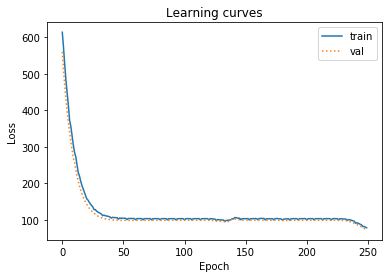

In [134]:
nn = NeuralNetwork(
    lambda: gen_data(train, 250, 20),
    lambda: gen_data(val, 1, 1),
    SOS,
    SOS
)

Fc1 = FcLayer(init_params(15, 10, scale=1),
              Sigmoid, #act func
              nn.gen_input,
              None
             )

Fc2 = FcLayer(init_params(10, 10, scale=2),
              Sigmoid,
              Fc1.poll_forward,
              Fc1.push_backward
             )

Fc3 = FcLayer(init_params(10, 10, scale=2),
              Sigmoid,
              Fc2.poll_forward,
              Fc2.push_backward
             )

Out = FcLayer(init_params(10, 1, scale=1),
              Linear,
              Fc3.poll_forward,
              Fc3.push_backward
             )

import matplotlib.pyplot as plt

def run_training(nn):
    training = []
    validation = []
    epoch = 0
    cost = 0
    for Z in nn.train(Out, 1e-5, 1e-5):
        cost += Z / train.shape[0]
        if nn.epoch > epoch:
            loss = 0
            epoch = nn.epoch
            for Zv in nn.val(Out):
                loss += Zv / val.shape[0]
            validation.append(loss)
            training.append(cost)
            cost = 0
    return training, validation

training, validation = run_training(nn)
ax = plt.figure().subplots(1)
ax.plot(range(nn.epoch), training, label='train')
ax.plot(range(nn.epoch), validation, label='val', linestyle=':')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.title("Learning curves")
plt.legend()
plt.show()

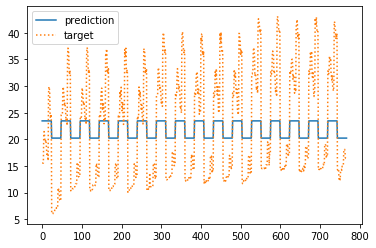

In [135]:
nn.val_set = lambda: gen_data(data, 1, 1)
target = []
pred = []
for Zv in nn.val(Out):
    target.append(nn.T[0][0])
    pred.append(Out.y[0][0])

plt.plot(range(N), pred, label='prediction')
plt.plot(range(N), target, label='target', linestyle=':')

plt.legend()
plt.show()

In [16]:
np.random.seed(123)
class NeuralNetwork2:
    def __init__(self, lr):
        self.weights1   = np.random.rand(15,10) 
        self.weights2   = np.random.rand(10,10)     
        self.weights3   = np.random.rand(10,10)
        self.lr         = lr
        pass

    def feedforward(self, x):
        self.layer1 = Sigmoid.f(np.dot(x, self.weights1))
        self.layer2 = Sigmoid.f(np.dot(self.layer1, self.weights2))
        self.output = np.dot(self.layer2, self.weights3)
        return self.output

    def backprop(self, x, cost):
        s2 = np.dot(cost, self.weights3.T) * Sigmoid.d(self.layer2)
        s1 = np.dot(s2, self.weights2.T) * Sigmoid.d(self.layer1)
        
        d_weights3 = np.dot(self.layer2.T, cost)
        d_weights2 = np.dot(self.layer1.T, s2)
        d_weights1 = np.dot(x.T, s1)
        
        print(self.weights3)
        
        self.weights3 += d_weights3 * self.lr
        self.weights2 += d_weights2 * self.lr
        self.weights1 += d_weights1 * self.lr
        pass

nn2 = NeuralNetwork2(0.0005)
epoch = 0
for X, T, e, step in gen_data(train, 1, 50):
    Y = nn2.feedforward(X)
    cost = SOS.d(T,Y)
    nn2.backprop(X, cost)
    if e > epoch:
        epoch = e
        loss = 0
        nn2.lr -= nn2.lr * 0.001
        for X, T, e, step in gen_data(val, 1, 1):
            Y = nn2.feedforward(X)
            loss += RMS.f(T, Y) / val.shape[0]
        #print("Epoch:", epoch, "Loss:", loss)

[[0.2082483  0.4433677  0.71560128 0.41051979 0.19100696 0.96749431
  0.65075037 0.86545985 0.02524236 0.26690581]
 [0.5020711  0.06744864 0.99303326 0.2364624  0.37429218 0.21401191
  0.10544587 0.23247979 0.30061014 0.63444227]
 [0.28123478 0.36227676 0.00594284 0.36571913 0.53388598 0.16201584
  0.59743311 0.29315247 0.63205049 0.02619661]
 [0.88759346 0.01611863 0.12695803 0.77716246 0.04589523 0.71099869
  0.97104614 0.87168293 0.71016165 0.95850974]
 [0.42981334 0.87287891 0.35595767 0.92976365 0.14877766 0.94002901
  0.8327162  0.84605484 0.12392301 0.5964869 ]
 [0.01639248 0.72118437 0.00773751 0.08482228 0.22549841 0.87512453
  0.36357632 0.53995994 0.56810321 0.22546336]
 [0.57214677 0.6609518  0.29824539 0.41862686 0.45308892 0.93235066
  0.58749375 0.94825237 0.55603475 0.50056142]
 [0.00353221 0.48088904 0.927455   0.19836569 0.05209113 0.40677889
  0.37239648 0.85715306 0.02661112 0.92014923]
 [0.680903   0.90422599 0.60752907 0.81195331 0.33554387 0.34956623
  0.38987423

In [97]:
a = np.array(np.random.rand(3,5))
a = np.sum(a, axis=1)
a

array([2.48510579, 3.35172188, 3.19123727])